In [1]:
import os
import re
from glob import glob
from importlib import reload

import numpy as np

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord
from astropy import table

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

# First parse/load the data 

In [3]:
import data_loaders

In [4]:
elvii_pairs = data_loaders.load_elvii(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/Burr&Hamilton.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Charybdis&Scylla.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Cher&Sonny.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Kauket&Kek.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Taurus&Orion.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Venus&Serana.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Zeus&Hera.txt


In [5]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [6]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Now some LG-simulating behavior

First we produce $M_{HI}$ for everything following Bradford+15

In [7]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [8]:
# produce HI masses for each table
for tab in elvii_pairs.values():
    Ms = tab['Mstar_preferred']
    tab['MHI'] = bradford_15_mstar_to_mgas(Ms)

Now we populate the tables with coordinates for an artificial "LG"

In [10]:
for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:736: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if axis == 'z':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:740: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif axis == 'y':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:744: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif axis == 'x':
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:866: RuntimeWarning: divide by zero encountered in power
  return super(Quantity, self).__pow__(other)
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astro

Now we pull the sensitivity from the GALFA image

In [11]:
for tab in elvii_pairs.values():
    for i in (0, 1):
        host_sc = SkyCoord(ra=tab['host{}_lon'.format(i)], 
                           dec=tab['host{}_lat'.format(i)])
        
        pxs = host_sc.to_pixel(galfa_sens_wcs)
        xp = np.round(pxs[0]).astype(int)
        yp = np.round(pxs[1]).astype(int)
        msk = (0<=xp)&(xp<galfa_sens.shape[0])&(0<=yp)&(yp<galfa_sens.shape[1])
        
        sens = np.zeros(len(tab), dtype=galfa_sens.dtype)*galfa_sens.unit
        sens[msk] = galfa_sens[xp[msk], yp[msk]]
        sens[sens==0] = np.inf
        
        tab['closest_sens{}'.format(i)] = sens

And then see if the line is detectable

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


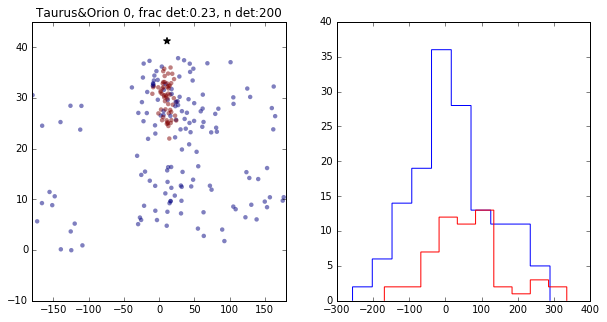

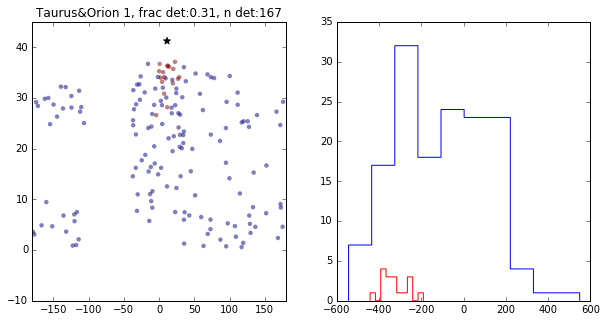

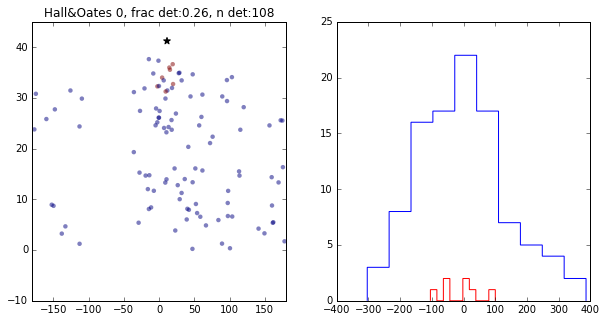

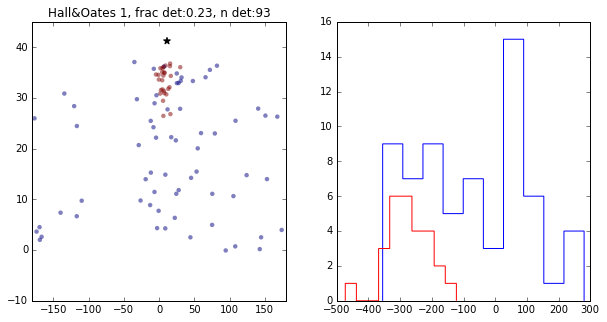

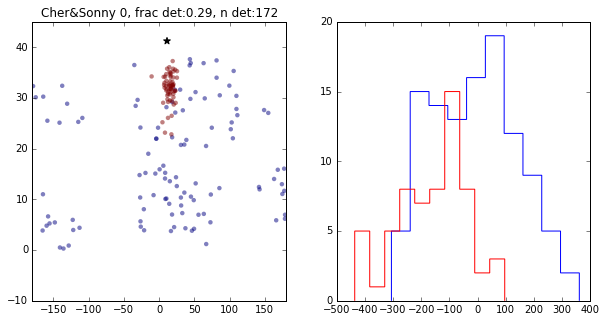

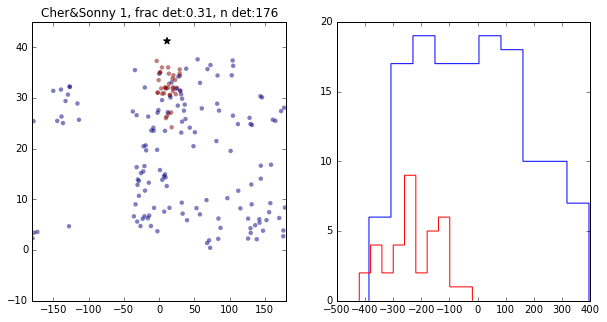

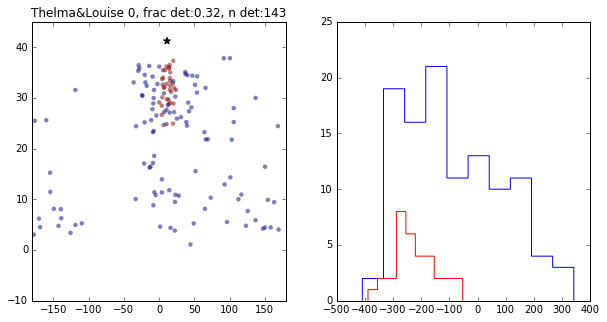

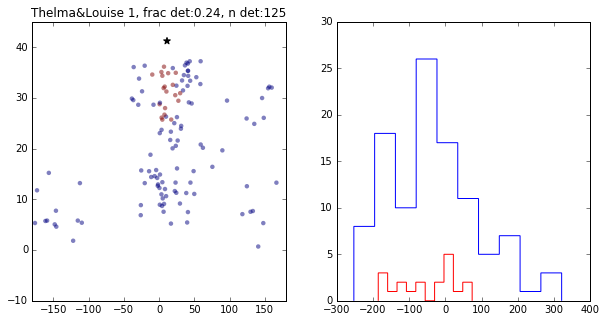

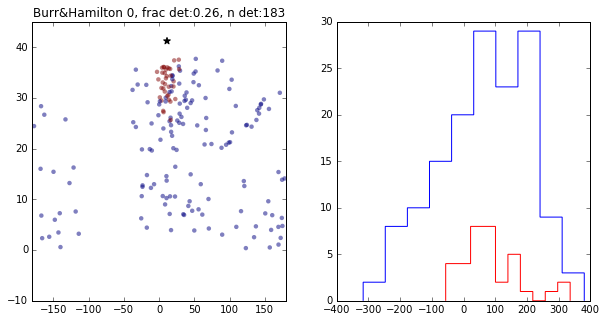

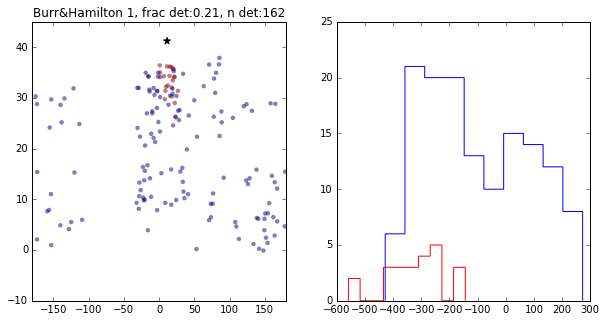

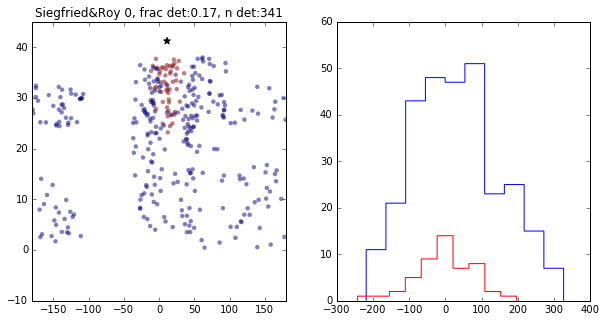

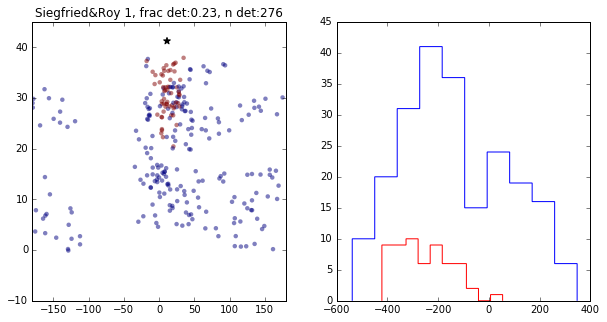

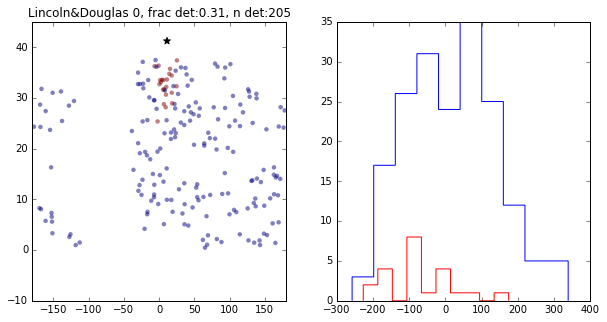

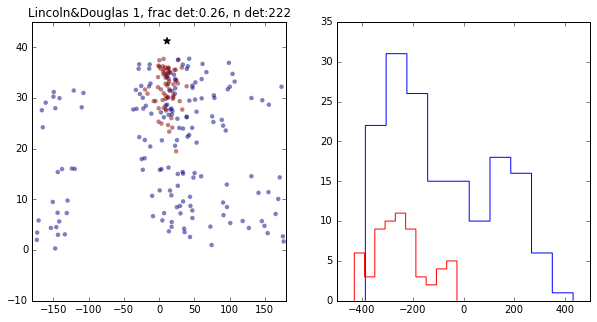

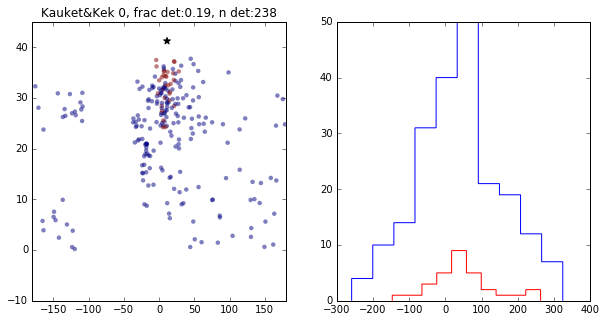

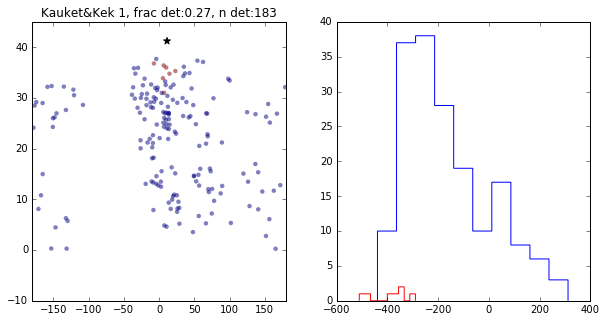

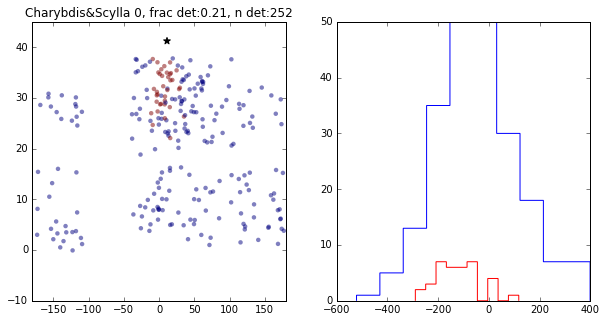

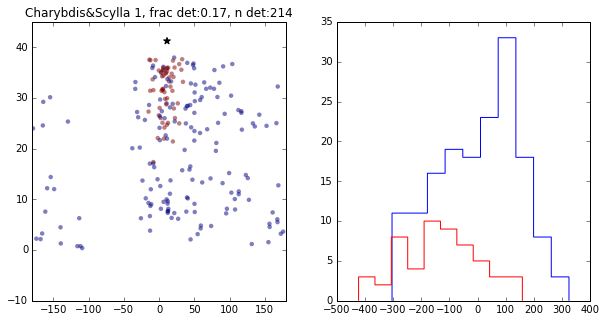

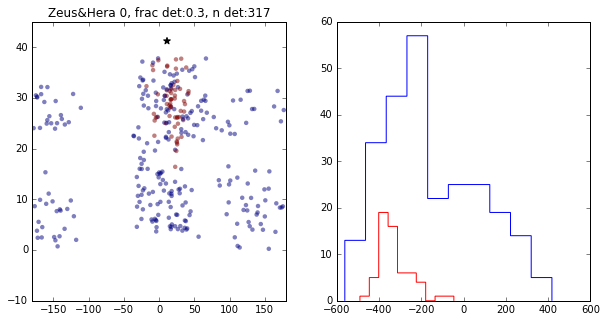

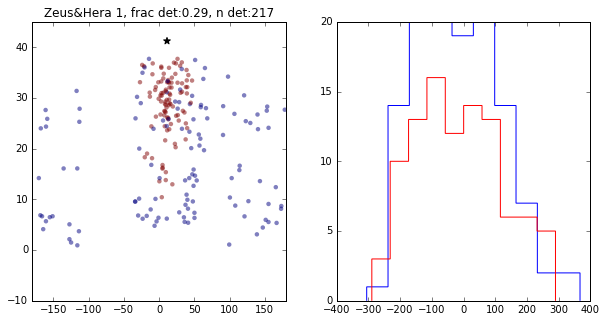

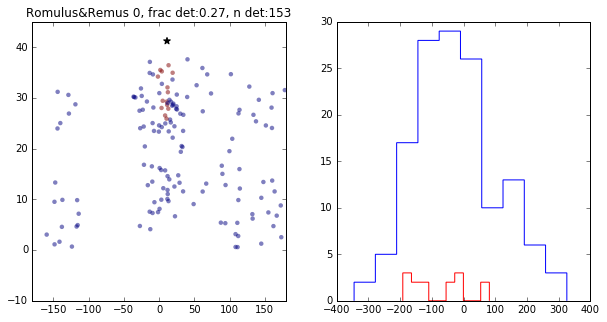

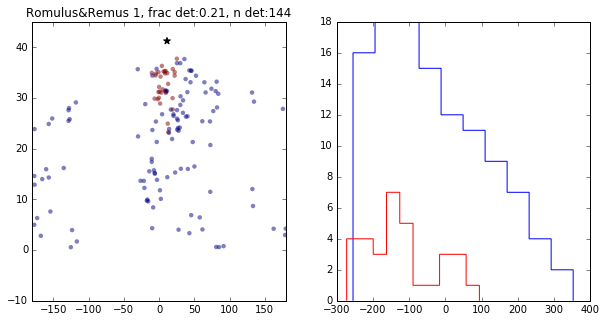

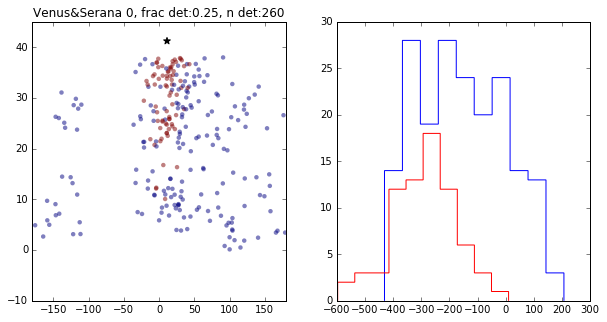

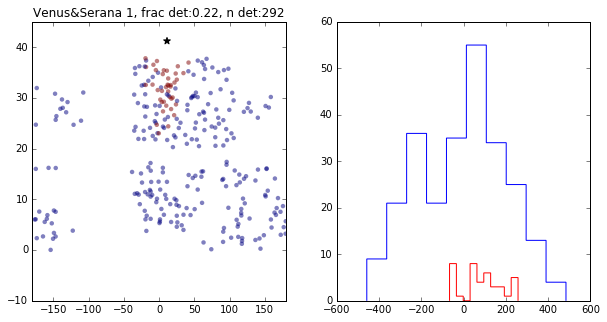

In [12]:
for name, tab in elvii_pairs.items():
    MHI = tab['MHI']
    for i in (0, 1):
        sens = tab['closest_sens{}'.format(i)]
        det = sens*tab['host{}_dist'.format(i)]**2 < MHI
        tab['detectable{}'.format(i)] = det
        
        fracdet = np.sum(det)/np.sum(np.isfinite(sens))
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        
        otheridx = 1 if i==0 else 0
        x, y, z = tab['X'], tab['Y'], tab['Z']
        dother = ((x-x[otheridx])**2+(y-y[otheridx])**2+(z-z[otheridx])**2)**0.5
        inrvir = dother < tab['Rvir'][otheridx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1,2, 1)
        plt.scatter(ra[det].wrap_at(180*u.deg).deg, dec[det].deg, c=inrvir[det],lw=0, alpha=.5)
        plt.scatter(ra[otheridx].wrap_at(180*u.deg).deg, dec[otheridx].deg, color='k', alpha=1, marker='*', s=50)
        plt.title('{} {}, frac det:{:.2}, n det:{}'.format(name, i, fracdet, np.sum(det)))
        plt.xlim(-180, 180)
        plt.ylim(-10, 45)
        
        plt.subplot(1,2, 2)
        vr = tab['host{}_vrlsr'.format(i)]
        plt.hist(vr[det&~inrvir].value, color='b', histtype='step')
        plt.hist(vr[det&inrvir].value, color='r', histtype='step')
        plt.axvline(vr[i])

In [25]:
for name, tab in elvii_pairs.items():
    dx = tab['X'][1] - tab['X'][0]
    dy = tab['Y'][1] - tab['Y'][0]
    dz = tab['Z'][1] - tab['Z'][0]
    d = (dx**2 + dy**2 + dz**2)**0.5
    
    dvx = tab['Vx'][1] - tab['Vx'][0]
    dvy = tab['Vy'][1] - tab['Vy'][0]
    dvz = tab['Vz'][1] - tab['Vz'][0]
    vsep = (dvx*dx + dvy*dy + dvz*dz)/d
    
    print(name , '{:.4}'.format(d.to(u.kpc)), '{:.4}'.format(vsep.to(u.km/u.s)))

Taurus&Orion 829.3 kpc -128.7 km / s
Hall&Oates 979.5 kpc -78.48 km / s
Cher&Sonny 966.2 kpc -173.5 km / s
Thelma&Louise 832.2 kpc -111.5 km / s
Burr&Hamilton 941.3 kpc -84.83 km / s
Siegfried&Roy 877.6 kpc -130.8 km / s
Lincoln&Douglas 780.4 kpc -142.0 km / s
Kauket&Kek 1.04e+03 kpc -106.1 km / s
Charybdis&Scylla 705.1 kpc -71.16 km / s
Zeus&Hera 595.2 kpc -200.7 km / s
Romulus&Remus 935.4 kpc -86.78 km / s
Venus&Serana 687.4 kpc -157.8 km / s
